In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utils import make_filter, convolution, hankel

References and extra reading:

GLM Tutorial from Jonathan Pillow : https://github.com/pillowlab/GLMspiketraintutorial

### Part 5 (Optional): Construct an LNP model for coupled neurons

For generating realistic spike counts from a population of neurons using the LNP model, the firing rate should also depend on the A) a neuron's individual spike-history B) the spike history of other neurons in the population. 

Here we simulate 2 coupled neurons using the LNP model. The spike count of each neuron depends on a common stimulus input, it's own spiking history and the other neuron's spiking history:

$\begin{align}
r^{(1)}_t &= exp(\sum_{k=1}^K \omega^{(1)}_k x_{t-k} + \sum_{n=1}^N h^{\text{self}}_n y^{(1)}_{t-n} +  \sum_{n=1}^N h^{\text{other}}_n y^{(2)}_{t-n} + b^{(1)})\\
r^{(2)}_t &= exp(\sum_{k=1}^K \omega^{(2)}_k x_{t-k} + \sum_{n=1}^N h^{\text{self}}_n y^{(2)}_{t-n} +  \sum_{n=1}^N h^{\text{other}}_n y^{(1)}_{t-n} + b^{(2)})\\
y^{(1)}_t &\sim \text{Poisson}(r^{(1)}\Delta t)\\
y^{(2)}_t &\sim \text{Poisson}(r^{(2)}\Delta t)
\end{align}$


Thus, at every timebin, in addition to the stimulus, the model should also receive as input, its own previous spikes (a vector of length $N$), weighted by the vector $\mathbf{h}^{\text{self}}$ of size $N$, and previous from other the neuron, weighted by a vector $\mathbf{h}^{\text{other}}$ of size $N$. We can rewrite the equations as follows:

$\mathbf{r}_t = W*\mathbf{x}_{t-K:t} + H\cdot\mathbf{y}_{t-N:t}$

where $\mathbf{r}_t = [r^{(1)}_t\text{    }r^{(2)}_t]$, $\mathbf{y}_t = [y^{(1)}_t\text{    }y^{(2)}_t]$, $W = [\omega^{(1)}\text{    }\omega^{(2)}]$, $H = \begin{bmatrix}
h^{\text{self}} & h^{\text{other}} \\
h^{\text{other}} & h^{\text{self}}
\end{bmatrix}$  

Algorithmically, this means that we can only generate spikes sequentially.

**Questions:**

a) Use the make_filter() method from utils.py to generate 2 stimulus filters for the 2 neurons, 1 spike-history filter $h^{\text{self}}$ and 1 cross-coupling filter $h^{\text{self}}$. 

b) Simulate responses $\mathbf{y}$ from this model to 200 repeats of Gaussian white noise stimulus of length 100. Calculate the peristimulus time histogram (PSTH) of each neuron's responses separately and compare it to the predicted rate $r$ from the model -- the 2 should match.

c) Calculate the STA for each neuron's filter.

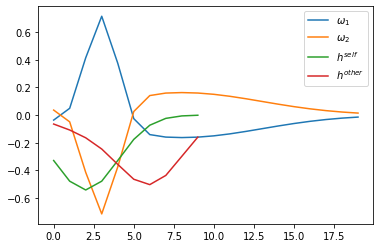

In [313]:
# Sample code


# Make filters for ω and h, set baseline
stim_lags = 20
hst_lags = 10
baseline_1 = 3
baseline_2 = 3
dt = .01
w_1 = make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
w_2 = - make_filter(lags=stim_lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2)
h_self = - make_filter(lags=hst_lags, mu1=2., mu2=2., s1=2., s2=2., eta=-.3)
h_other =  - make_filter(lags=hst_lags, mu1=6., mu2=2., s1=2., s2=2., eta=-.2)

plt.plot(w_1, label='$\omega_1$')
plt.plot(w_2, label='$\omega_2$')
plt.plot(h_self, label='$h^{self}$')
plt.plot(h_other, label='$h^{other}$')
plt.legend()

In [314]:
# Generate stimulus
stim = np.random.normal(size=100)
stim = np.tile(stim, 300).reshape(300, -1)

# Calculate log firing rate from stimulus filter & baseline terms
X = hankel(stim_lags, stim)
z_1 = X.dot(w_1).reshape(300, -1) + baseline_1
z_2 = X.dot(w_2).reshape(300, -1) + baseline_2

y_1 = np.zeros_like(stim)
r_1 = np.zeros_like(stim)

y_2 = np.zeros_like(stim)
r_2 = np.zeros_like(stim)

# Simulate responses
y_1[:, :hst_lags] = np.random.poisson(np.exp(z_1[:, :hst_lags]))
y_2[:, :hst_lags] = np.random.poisson(np.exp(z_2[:, :hst_lags]))

for t in range(hst_lags, stim.shape[1]):
    # Update log firing rate
    z_1[:, t] = z_1[:, t] + y_1[:, t-hst_lags : t].dot(h_self) + y_2[:, t-hst_lags : t].dot(h_other)
    z_2[:, t] = z_2[:, t] + y_2[:, t-hst_lags : t].dot(h_self) + y_1[:, t-hst_lags : t].dot(h_other)
    
    # Calculate firing rate
    r_1[:, t] = np.exp(z_1[:, t])
    r_2[:, t] = np.exp(z_2[:, t])
    
    # Calculate response
    y_1[:, t] = np.random.poisson(dt * r_1[:, t])
    y_2[:, t] = np.random.poisson(dt * r_2[:, t])

In [315]:
# Calculate STA
sta_1 = y_1.flatten().dot(X) / y_1.sum()
sta_2 = y_2.flatten().dot(X) / y_2.sum()

In [316]:
from scipy.special import factorial, gammaln
from scipy.optimize import minimize as scipy_minimize

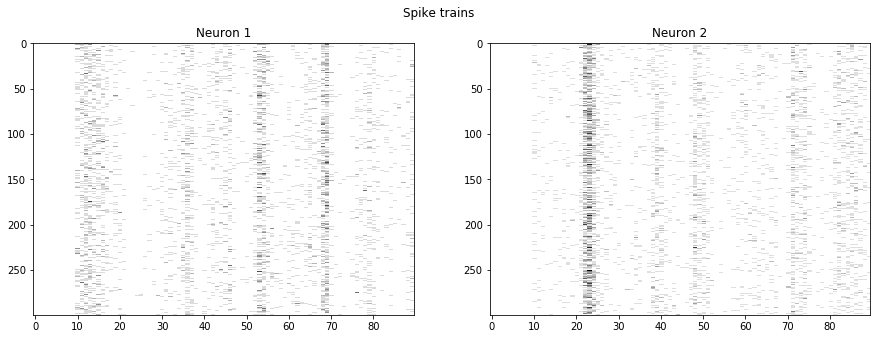

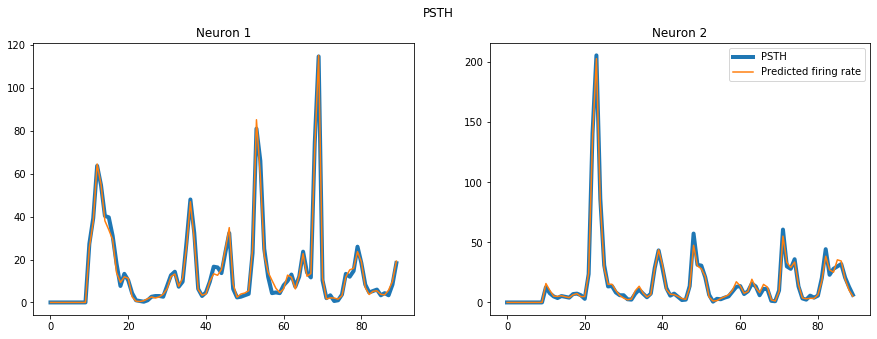

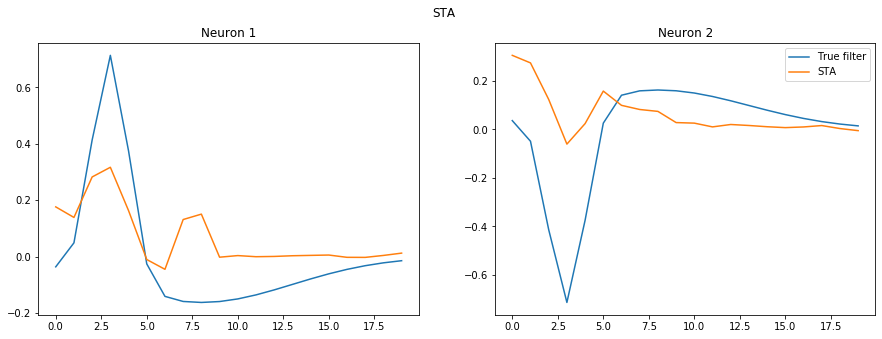

In [317]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Spike trains")
ax1.set_title("Neuron 1")
ax1.imshow(y_1[:, hst_lags:], cmap='binary', aspect='auto')
ax2.set_title("Neuron 2")
ax2.imshow(y_2[:, hst_lags:], cmap='binary', aspect='auto')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("PSTH")
ax1.set_title("Neuron 1")
ax1.plot(y_1[:, hst_lags:].mean(0) / dt, lw=4, label='PSTH')
ax1.plot(r_1[:, hst_lags:].mean(0), label="Predicted firing rate")
ax2.set_title("Neuron 2")
ax2.plot(y_2[:, hst_lags:].mean(0) / dt, lw=4, label='PSTH')
ax2.plot(r_2[:, hst_lags:].mean(0), label="Predicted firing rate")
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("STA")
ax1.set_title("Neuron 1")
ax1.plot(w_1, label="True filter")
ax1.plot(sta_1, label='STA')
ax2.set_title("Neuron 2")
ax2.plot(w_2, label='True filter')
ax2.plot(sta_2, label="STA")
plt.legend()
plt.show()


In [318]:
from scipy.special import factorial, gammaln
from scipy.optimize import minimize as scipy_minimize

def cost(params, stimulus, response, dt):
    """Returns log likelihood of a linear-nonlinear Poisson model.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    log_likelihood : float value.
    """
    _filter = params[:-1]
    baseline = params[-1]
    
    stimulus = stimulus.flatten()
    response = response.flatten()
    
    X = hankel(len(_filter), stimulus)
    z = X.dot(_filter) + baseline
    r = dt * np.exp(z)
    
    # One way to calculate log likelihood
#     likelihood = np.prod(r**response * np.exp(-r) / factorial(response))
#     log_likelihood = np.log(likelihood)
    
    # Another way to calculate log likelihood
    log_likelihood = np.sum((response * (z + np.log(dt))) - r - gammaln(response + 1))
    
    return log_likelihood

def cost(params, stimulus, response_1, response_2, dt):
    """Returns log likelihood of a linear-nonlinear Poisson model.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    log_likelihood : float value.
    """
    
    w_1 = params[:20]
    w_2 = params[20:40]
    h_1 = params[40:50]
    h_2 = params[50:60]
    
    trials,T = response_1.shape
    filter_len = len(w_1)
    h_len = len(h_1)
    
    baseline_1 = params[-2]
    baseline_2 = params[-1]
    
    X_w = hankel(filter_len, stimulus[:,:-h_len])
    X_h1 = hankel(h_len, response_1[:,h_len:])
    X_h2 = hankel(h_len, response_2[:,h_len:])
    
    z_1 = X_w.dot(w_1) + X_h1.dot(h_1) + X_h2.dot(h_2) + baseline_1
    z_2 = X_w.dot(w_2) + X_h1.dot(h_2) + X_h2.dot(h_1) + baseline_2
    
    response_1 = response_1[:,h_len:-h_len]
    response_2 = response_2[:,h_len:-h_len]    
    
    z_1 = z_1.reshape(trials,T-h_len)[:,h_len:]
    z_2 = z_2.reshape(trials,T-h_len)[:,h_len:]
    
    r_1 = dt * np.exp(z_1)
    r_2 = dt * np.exp(z_2)
    
    log_likelihood = np.sum((response_1 * (z_1 + np.log(dt))) - r_1 - gammaln(response_1 + 1)) + np.sum((response_2 * (z_2 + np.log(dt))) - r_2 - gammaln(response_2 + 1))
    
    return log_likelihood #,r_1,response_1
    
    
def nloglike(params, stimulus, response_1, response_2, dt):
    """Returns negative log likelihood of a linear-nonlinear Poisson model.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    nloglike : float value.
    """
    return -cost(params, stimulus, response_1, response_2, dt)


def minimize_mle(stimulus, response1, response2, stim_lags, hst_lags, dt):
    """Returns the ML estimate of the parameters of a linear-nonlinear Poisson model.
    Parameters:
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    _filter : vector of floats. ML estimate of the convolutional filter.
    baseline : float value. ML estimate of the baseline offset. 
    """
    init = np.zeros(2*stim_lags + 2*hst_lags + 2)
    params = scipy_minimize(nloglike, init, args=(stimulus, response1, response2, dt), jac=False).x
    return params[:-1], params[-1]

In [319]:
gt_params = np.concatenate([w_1,w_2,h_self,h_other,np.array(baseline_1)[None],np.array(baseline_2)[None]],0)
cost(gt_params,stim,y_1,y_2,dt)

-18544.376854955197

In [320]:
init = np.zeros(2*stim_lags + 2*hst_lags + 2)
params = scipy_minimize(nloglike, init, args=(stim, y_1, y_2, dt), jac=False).x

Text(0.5, 1.0, 'h other')

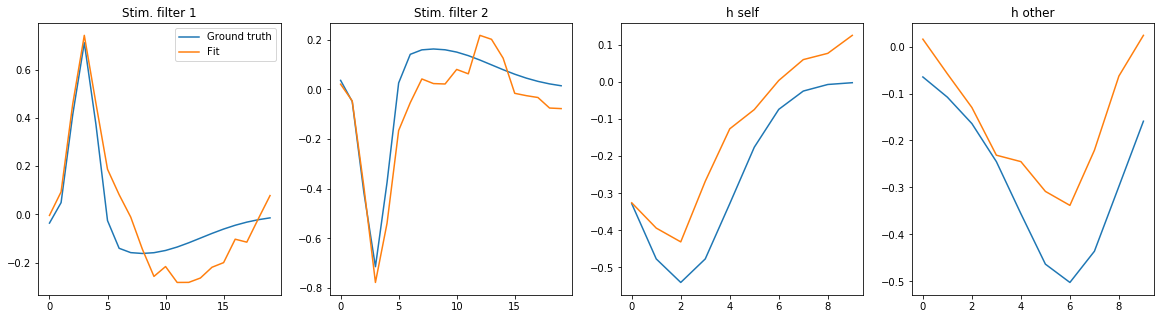

In [321]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(w_1, label='Ground truth')
plt.plot(params[:20], label='Fit')
plt.legend()
plt.title('Stim. filter 1')
plt.subplot(142)
plt.plot(w_2, label='Filter 2')
plt.plot(params[20:40], label='Fit')
plt.title('Stim. filter 2')
plt.subplot(143)
plt.plot(h_self, label='h self')
plt.plot(params[40:50], label='Fit')
plt.title('h self')
plt.subplot(144)
plt.plot(h_other, label='h other')
plt.plot(params[50:60], label='Fit')
plt.title('h other')